In [1]:
import torch
import scene
from scene import Scene
import os
from tqdm import tqdm
from os import makedirs
from gaussian_renderer import render
import torchvision
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args
from gaussian_renderer import GaussianModel

In [2]:
# import the read_extrinsics_binary, read_intrinsics_binary, readColmapCameras

from scene.colmap_loader import * 
from scene.dataset_readers import *  
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 




In [3]:
cam_extrinsics = read_extrinsics_binary('./data/custom/work/sparse/0/images.bin')
cam_intrinsics = read_intrinsics_binary('./data/custom/work/sparse/0/cameras.bin')


In [4]:
print(cam_intrinsics)

{1: Camera(id=1, model='PINHOLE', width=1263, height=710, params=array([1114.10531051, 1108.82028345,  631.5       ,  355.        ]))}


In [5]:
scene_info = readColmapSceneInfo('./data/custom/work', images=None, eval=True, llffhold=8)


Reading camera 258/258


In [6]:
scene_info

SceneInfo(point_cloud=BasicPointCloud(points=array([[ 8.629861 ,  0.7836478, -4.147699 ],
       [ 7.6343307,  1.137932 , -4.83588  ],
       [23.577301 , -1.538512 , -8.354913 ],
       ...,
       [-1.3274001, -7.573485 , 13.970032 ],
       [-2.2521873, -7.4987183, 14.744595 ],
       [-3.3423238, -7.8006716, 15.755141 ]], dtype=float32), colors=array([[0.37254902, 0.56862745, 0.06666667],
       [0.56862745, 0.79215686, 0.29803922],
       [0.72941176, 0.59607843, 0.56078431],
       ...,
       [0.66666667, 0.63921569, 0.68627451],
       [0.37254902, 0.3254902 , 0.38823529],
       [0.52156863, 0.48627451, 0.54509804]]), normals=array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]], dtype=float32)), train_cameras=[CameraInfo(uid=1, R=array([[-0.92091918,  0.15787924, -0.35634534],
       [-0.04122794,  0.86969411,  0.49186625],
       [ 0.38756692,  0.46766045, -0.79440895]]), T=array([ 0.78946567

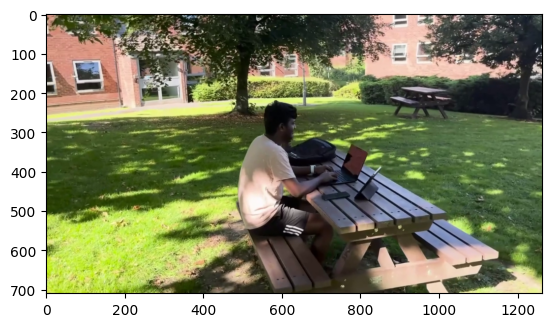

In [7]:
plt.imshow(scene_info.train_cameras[159].image)

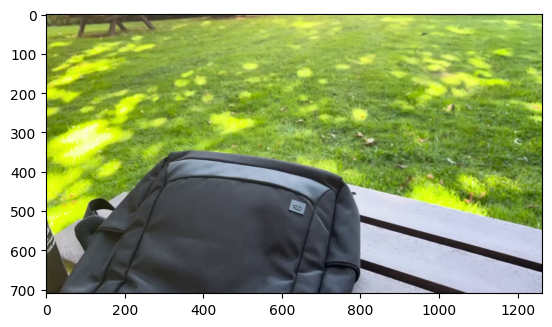

In [8]:
plt.imshow(scene_info.test_cameras[0].image)

In [9]:
def convert2df(cam_info):
    df = pd.DataFrame(columns=['img','translation','rotation'])
    for item in cam_info:
        df = df.append({'img': item.image_name, 'translation': item.T, 'rotation': item.R}, ignore_index=True)
    df['rotation'] = df['rotation'].apply(lambda x: x.flatten())
    df['tx'] = df['translation'].apply(lambda x: x[0]) 
    df['ty'] = df['translation'].apply(lambda x: x[1])
    df['tz'] = df['translation'].apply(lambda x: x[2])

    df['r11'] = df['rotation'].apply(lambda x: x[0])
    df['r12'] = df['rotation'].apply(lambda x: x[1])
    df['r13'] = df['rotation'].apply(lambda x: x[2])
    df['r21'] = df['rotation'].apply(lambda x: x[3])
    df['r22'] = df['rotation'].apply(lambda x: x[4])
    df['r23'] = df['rotation'].apply(lambda x: x[5])
    df['r31'] = df['rotation'].apply(lambda x: x[6])
    df['r32'] = df['rotation'].apply(lambda x: x[7])
    df['r33'] = df['rotation'].apply(lambda x: x[8])
    df.drop(['translation', 'rotation'], axis=1, inplace=True)
    return df

    

In [10]:
df_train = convert2df(scene_info.train_cameras)
df_test = convert2df(scene_info.test_cameras)

In [11]:
gaze_info = pd.read_csv('gaze_results_attr.csv')
gaze_info['image_name'] = gaze_info['image_name'].apply(lambda x: x.split('.')[0])

In [12]:
# join gaze info with the camera info based on image name 
df_train_gaze = df_train.merge(gaze_info, left_on='img', right_on='image_name')

In [13]:
df_train_gaze

,img,tx,ty,tz,r11,r12,r13,r21,r22,r23,r31,r32,r33,image_name,gaze_direction,head_position
0,frame_00001,0.789466,-0.308395,4.727974,-0.920919,0.157879,-0.356345,-0.041228,0.869694,0.491866,0.387567,0.467660,-0.794409,frame_00001,"[40.0, 38.0]","[697.2, 314.5, 743.18, 368.95]"
1,frame_00002,0.823900,-0.311073,4.722885,-0.923243,0.158026,-0.350214,-0.038004,0.869474,0.492515,0.382332,0.468020,-0.796730,frame_00002,"[40.0, 38.0]","[705.3, 314.6, 750.07, 367.84]"
2,frame_00003,0.864455,-0.316078,4.717421,-0.926052,0.158608,-0.342450,-0.033494,0.869279,0.493186,0.375908,0.468185,-0.799685,frame_00003,"[42.0, 37.0]","[715.0, 312.3, 763.4, 369.17]"
3,frame_00004,0.898757,-0.322044,4.715181,-0.929486,0.158942,-0.332855,-0.028119,0.869238,0.493593,0.367783,0.468147,-0.803476,frame_00004,"[43.0, 37.0]","[725.3, 315.9, 770.07, 365.51]"
4,frame_00005,0.911308,-0.328002,4.706850,-0.933638,0.159042,-0.320976,-0.021568,0.869453,0.493544,0.357568,0.467714,-0.808324,frame_00005,"[43.0, 37.0]","[728.1, 310.5, 775.29, 364.95]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,frame_00166,0.592113,-0.451398,3.705345,-0.419425,0.312913,-0.852155,-0.293309,0.841653,0.453421,0.859100,0.440121,-0.261230,frame_00166,"[44.0, 34.0]","[663.9, 268.7, 713.51, 344.93]"
131,frame_00167,0.587851,-0.458833,3.704793,-0.456171,0.306220,-0.835546,-0.283511,0.839995,0.462634,0.843522,0.447927,-0.296365,frame_00167,"[61.0, 4.0]","[659.9, 264.7, 709.51, 340.93]"
132,frame_00168,0.577994,-0.450904,3.699600,-0.490754,0.299737,-0.818119,-0.273125,0.838719,0.471120,0.827383,0.454653,-0.329739,frame_00168,"[61.0, 5.0]","[654.7, 262.2, 706.73, 344.48]"
133,frame_00169,0.591975,-0.444334,3.663644,-0.524494,0.293080,-0.799381,-0.262469,0.837503,0.479269,0.809948,0.461187,-0.362341,frame_00169,"[41.0, 36.0]","[657.6, 266.5, 710.84, 345.15]"


In [14]:
df_train_gaze.to_csv('df_train_gaze.csv', index=False)

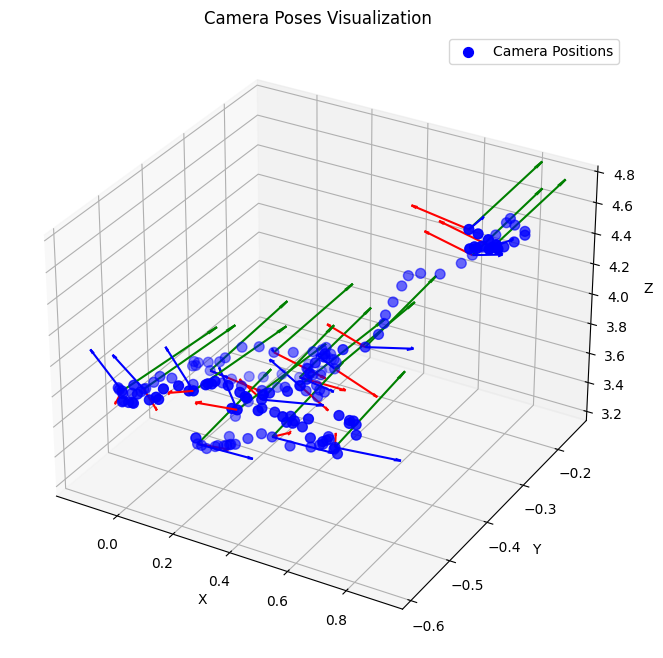

In [15]:
# Visualize the camera pose using the extrinsic and intrinsic parameters 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_camera_poses(df):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot camera positions
    ax.scatter(df['tx'], df['ty'], df['tz'], c='blue', marker='o', s=50, label='Camera Positions')
    
    count = 0
    # Plot camera orientations
    for _, row in df.iterrows():
        if count % 10 == 0:
    
            R = np.array([[row['r11'], row['r12'], row['r13']],
                        [row['r21'], row['r22'], row['r23']],
                        [row['r31'], row['r32'], row['r33']]])
            t = np.array([row['tx'], row['ty'], row['tz']])
            
            # Plot coordinate axes
            for i, c in enumerate(['r', 'g', 'b']):
                ax.quiver(t[0], t[1], t[2], 
                        R[0, i], R[1, i], R[2, i], 
                        length=0.2, color=c, arrow_length_ratio=0.1)
        count += 1

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Camera Poses Visualization')
    ax.legend()
    plt.show()


# Visualize camera poses for training data
plot_camera_poses(df_train)
# plot_camera_poses(df_train[df_train['img']=='frame_00009'])

# Visualize camera poses for test data
# plot_camera_poses(df_test)


In [16]:
num_images = 3 
cx,cy = read_intrinsics_binary('./data/custom/work/sparse/0/cameras.bin')[1].params[2:]
fx,fy = read_intrinsics_binary('./data/custom/work/sparse/0/cameras.bin')[1].params[:2]
camera_matrix = np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]])
images = [scene_info.train_cameras[6].image,scene_info.train_cameras[9].image,scene_info.train_cameras[12].image]
R_cameras = [scene_info.train_cameras[6].R,scene_info.train_cameras[9].R,scene_info.train_cameras[12].R]
t_cameras = [scene_info.train_cameras[6].T,scene_info.train_cameras[9].T,scene_info.train_cameras[12].T]

head_positions = [df_train_gaze.iloc[6]['head_position'],df_train_gaze.iloc[9]['head_position'],df_train_gaze.iloc[12]['head_position']]
eye_gaze_directions = [df_train_gaze.iloc[6]['gaze_direction'],df_train_gaze.iloc[9]['gaze_direction'],df_train_gaze.iloc[12]['gaze_direction']]


In [17]:
camera_matrix

array([[1.11410531e+03, 0.00000000e+00, 6.31500000e+02],
       [0.00000000e+00, 1.10882028e+03, 3.55000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

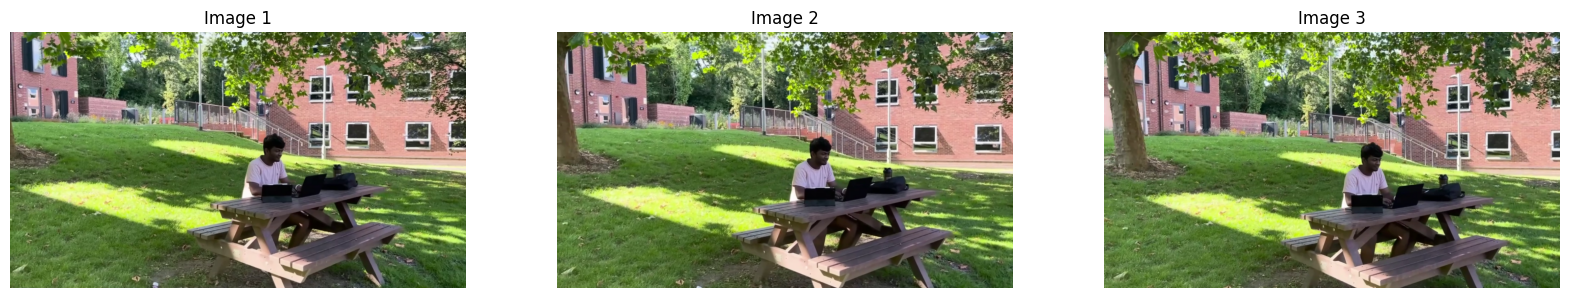

In [18]:
# grid for 3 plots 
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(f'Image {i+1}')
    ax.axis('off')

plt.show()

In [19]:
print(head_positions)
print(eye_gaze_directions)

['[715.0, 309.5, 763.4, 363.95]', '[710.9, 315.0, 760.51, 375.5]', '[722.9, 335.2, 772.51, 393.28]']
['[45.0, 36.0]', '[43.0, 36.0]', '[47.0, 37.0]']


In [20]:
# find the extrinsic parameters of an hypothetical camera placed at the human eye point of view in an image  

def calculate_eye_params(camera_matrix, R_camera, t_camera, head_position, eye_gaze_direction, head_depth):
    # Calculate the ray direction in world coordinates
    ray_direction = np.dot(camera_matrix, np.array([0, 0, 1]))
    ray_direction = ray_direction / np.linalg.norm(ray_direction)

    # Calculate the ray origin in world coordinates
    ray_origin = np.dot(camera_matrix, np.array([0, 0, 0])) 
    ray_origin = ray_origin / np.linalg.norm(ray_origin)

    # Calculate the eye translation vector
    eye_translation = head_position - ray_origin

    # Calculate the eye rotation matrix
    eye_rotation = np.dot(np.linalg.inv(R_camera), eye_gaze_direction)

    return eye_rotation, eye_translation

def average_rotations(rotations):
    """
    Average a list of rotation matrices.
    """
    R_avg = np.eye(3)
    for R in rotations:
        R_avg = np.dot(R_avg, R)
    return R_avg

def average_translations(translations):
    """
    Average a list of translation vectors.
    """
    t_avg = np.zeros(3)
    for t in translations:
        t_avg += t
    return t_avg / len(translations)






In [ ]:


# Example data for multiple images (replace with your actual data)
num_images = 3
camera_matrices = [np.array([[1000, 0, 500], [0, 1000, 500], [0, 0, 1]]) for _ in range(num_images)]
R_cameras = [np.eye(3) for _ in range(num_images)]
t_cameras = [np.array([0, 0, -5 - i*0.1]) for i in range(num_images)]
head_positions = [np.array([400 + i*10, 300 + i*5]) for i in range(num_images)]
eye_gaze_directions = [np.array([0.1, 0.1, -1]) for _ in range(num_images)]
head_depths = [1.0 for _ in range(num_images)]

# Test camera parameters
R_test = np.array([[0.9, 0.1, 0], [-0.1, 0.9, 0], [0, 0, 1]])
t_test = np.array([0.1, 0.2, -4.8])

# Calculate eye parameters for each image
eye_rotations = []
eye_translations = []

for i in range(num_images):
    R_eye, t_eye = calculate_eye_params(
        camera_matrices[i], R_cameras[i], t_cameras[i],
        head_positions[i], eye_gaze_directions[i], head_depths[i]
    )
    eye_rotations.append(R_eye)
    eye_translations.append(t_eye)

# Average the results
R_eye_avg = average_rotations(eye_rotations)
t_eye_avg = average_translations(eye_translations)

# Compare with test parameters
def compare_parameters(R_calc, t_calc, R_test, t_test):
    R_diff = R_calc @ R_test.T
    angle_diff = np.arccos((np.trace(R_diff) - 1) / 2)
    angle_diff_deg = np.degrees(angle_diff)
    t_diff = np.linalg.norm(t_calc - t_test)
    return angle_diff_deg, t_diff

angle_diff, t_diff = compare_parameters(R_eye_avg, t_eye_avg, R_test, t_test)

print("Averaged Eye Rotation Matrix:\n", R_eye_avg)
print("Averaged Eye Translation Vector:", t_eye_avg)
print("Test Eye Rotation Matrix:\n", R_test)
print("Test Eye Translation Vector:", t_test)
print(f"Rotation Difference: {angle_diff:.2f} degrees")
print(f"Translation Difference: {t_diff:.3f} units")

# If the differences are large, you might want to refine your calculations
if angle_diff > 10 or t_diff > 0.5:  # These thresholds can be adjusted
    print("Warning: Large difference between calculated and test parameters.")
    print("Consider refining your calculations or checking your input data.")
    
    # One possible refinement: use the test rotation, but keep the calculated translation
    R_eye_refined = R_test
    t_eye_refined = t_eye_avg
    
    print("Refined Eye Rotation Matrix (using test rotation):\n", R_eye_refined)
    print("Refined Eye Translation Vector (keeping calculated translation):", t_eye_refined)